In [35]:
import sys
import os
# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(),'../'))

# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
historical_prices = func_lib.create_hist_prices('2000-01-01', '2025-01-10')

In [4]:
list_of_momentums = [1]
total_returns = func_lib.computingReturns(historical_prices, list_of_momentums)

In [6]:
returns = total_returns['1_d_returns']
returns = returns[returns.index.get_level_values(0)=='AAPL']

In [7]:
window = 2

In [8]:
gain = returns[returns>0].dropna().rolling(window=window).mean()
gain.name = 'gain'

loss = returns[returns<0].dropna().rolling(window=window).mean()
loss.name = 'loss'

In [9]:
returns = pd.merge(returns, gain, left_index=True, right_index=True, how='left')
returns = pd.merge(returns, loss, left_index=True, right_index=True, how='left')

In [10]:
returns.head()

1_d_returns      gain      loss
Ticker Date                                       
AAPL   2000-01-04    -0.084310       NaN       NaN
       2000-01-05     0.014633       NaN       NaN
       2000-01-06    -0.086539       NaN -0.085424
       2000-01-07     0.047369  0.031001       NaN
       2000-01-10    -0.017587       NaN -0.052063

In [11]:
returns = returns.ffill()
returns.dropna(inplace=True)

In [12]:
ratio = returns['gain']/abs(returns['loss'])
rsi = 100 - (100 / (1 + ratio))

In [13]:
def calculate_rsi(returns, window=14):
    gain = returns[returns>0].dropna().rolling(window=window).mean()
    gain.name = 'gain'
    
    loss = returns[returns<0].dropna().rolling(window=window).mean()
    loss.name = 'loss'

    returns = pd.merge(returns, gain, left_index=True, right_index=True, how='left')
    returns = pd.merge(returns, loss, left_index=True, right_index=True, how='left')

    returns = returns.ffill()
    returns.dropna(inplace=True)

    ratio = returns['gain']/abs(returns['loss'])
    rsi = 100 - (100 / (1 + ratio))
    
    
    return rsi

In [14]:
# Calculate RSI for each ticker separately and add to the DataFrame
total_returns['RSI'] = total_returns.groupby('Ticker')[['1_d_returns']].transform(calculate_rsi)

In [15]:
total_returns.head()

F_1_d_returns  1_d_returns  RSI
Ticker Date                                       
A      2000-01-04      -0.062030    -0.076389  NaN
       2000-01-05      -0.038076    -0.062030  NaN
       2000-01-06       0.083333    -0.038076  NaN
       2000-01-07       0.060577     0.083333  NaN
       2000-01-10      -0.013600     0.060577  NaN

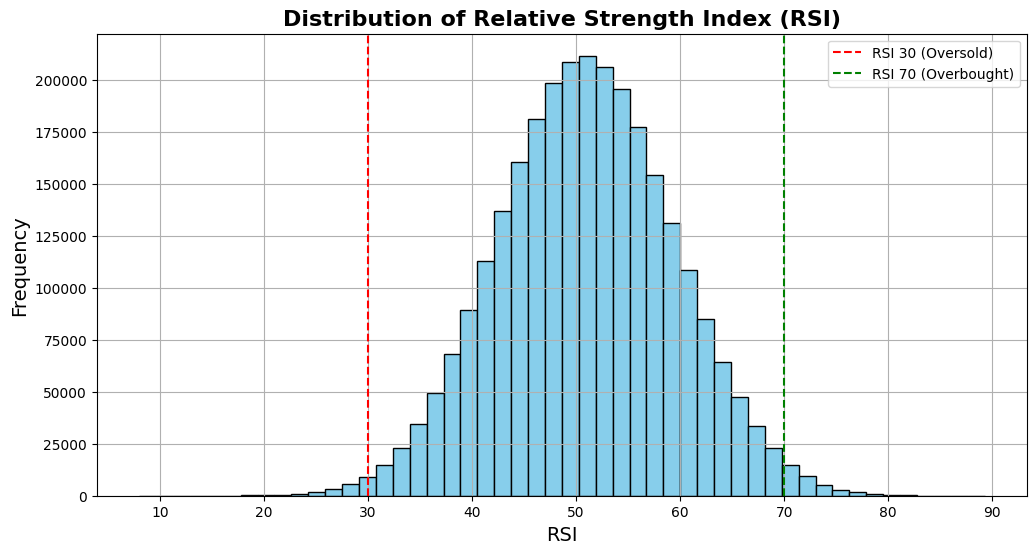

In [31]:
# Histograma
plt.figure(figsize=(12, 6))
plt.hist(total_returns['RSI'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=30, color='red', linestyle='--', label='RSI 30 (Oversold)')
plt.axvline(x=70, color='green', linestyle='--', label='RSI 70 (Overbought)')
plt.title('Distribution of Relative Strength Index (RSI)', fontsize=16, fontweight='bold')
plt.xlabel('RSI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

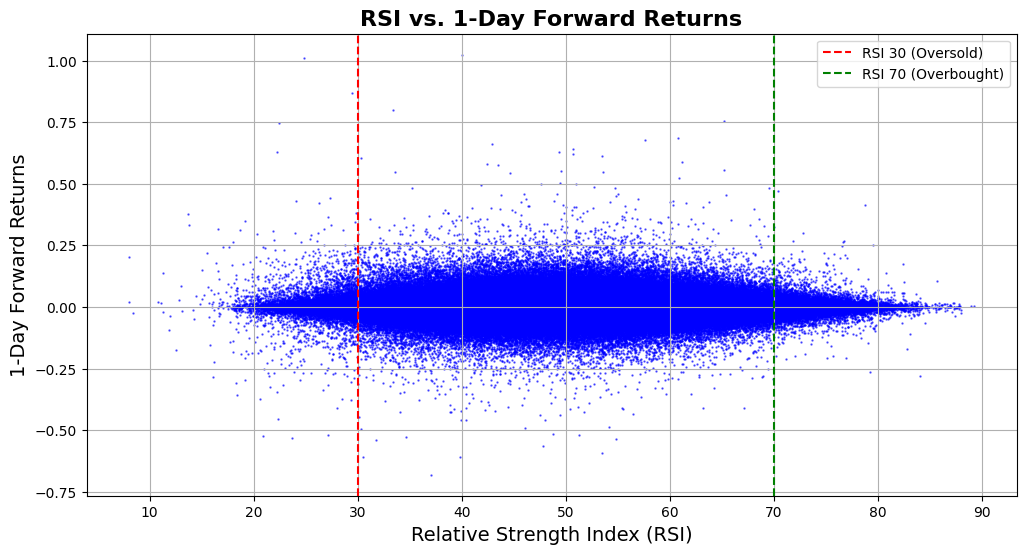

In [32]:
# Scatter Plot
plt.figure(figsize=(12, 6))
plt.scatter(total_returns['RSI'], total_returns['F_1_d_returns'], color='blue', alpha=0.6, s=0.5)
plt.axvline(x=30, color='red', linestyle='--', label='RSI 30 (Oversold)')
plt.axvline(x=70, color='green', linestyle='--', label='RSI 70 (Overbought)')
plt.title('RSI vs. 1-Day Forward Returns', fontsize=16, fontweight='bold')
plt.xlabel('Relative Strength Index (RSI)', fontsize=14)
plt.ylabel('1-Day Forward Returns', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [25]:
total_returns[['F_1_d_returns', 'RSI']].corr().style.background_gradient()

,F_1_d_returns,RSI
F_1_d_returns,1.000000,-0.004541
RSI,-0.004541,1.000000


<Axes: xlabel='Quantiles'>

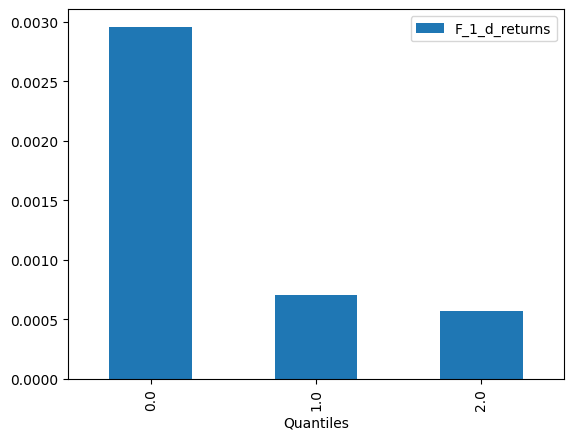

In [26]:
feature = 'RSI'
target = 'F_1_d_returns'

# Specify custom bin boundaries
bin_boundaries = [0, 30, 70, 100]

total_returns['Quantiles'] = total_returns.groupby(level='Date')[feature].transform(lambda x: pd.cut(x, bins=bin_boundaries, labels=False))

total_returns.groupby('Quantiles')[[target]].mean().plot(kind='bar', legend=True)

In [28]:
total_returns[total_returns['RSI']<30].describe()

,F_1_d_returns,1_d_returns,RSI,Quantiles
count,16683.000000,16683.000000,16683.000000,16683.0
mean,0.002959,-0.014811,27.275294,0.0
std,0.043010,0.048333,2.516929,0.0
min,-0.531402,-0.680525,8.007120,0.0
25%,-0.009914,-0.019646,26.159002,0.0
50%,0.001498,-0.001730,28.015018,0.0
75%,0.013396,0.005508,29.165583,0.0
max,1.010101,0.350951,29.999993,0.0


In [29]:
def calculate_rsi(returns, window=14):
    # Calcular ganhos e perdas
    gain = np.where(returns > 0, returns, 0)
    loss = np.where(returns < 0, abs(returns), 0)
    
    # Calcular médias móveis exponenciais
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    
    # Calcular o RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

      RSI_Bin      mean       std
0    Oversold  0.002959  0.043010
1     Neutral  0.000702  0.022985
2  Overbought  0.000570  0.021757


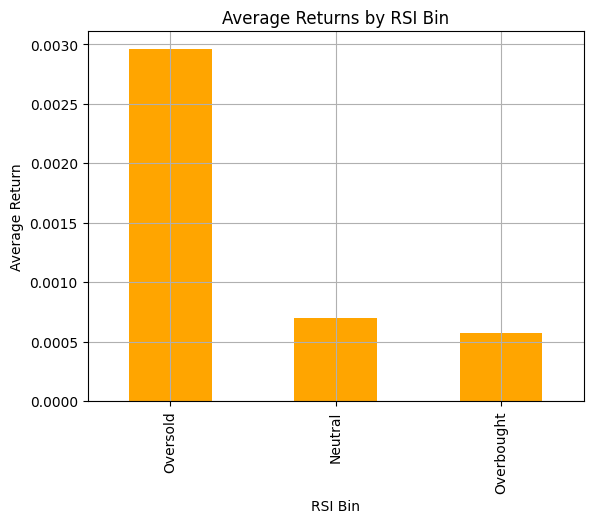

In [36]:
# Dividir o RSI em bins personalizados
bin_boundaries = [0, 30, 70, 100]
total_returns['RSI_Bin'] = pd.cut(total_returns['RSI'], bins=bin_boundaries, labels=['Oversold', 'Neutral', 'Overbought'])

# Calcular média e desvio padrão dos retornos por bin
rsi_analysis = total_returns.groupby('RSI_Bin', observed=False)['F_1_d_returns'].agg(['mean', 'std']).reset_index()

# Exibir a análise
print(rsi_analysis)

# Plotar os retornos médios por bin
rsi_analysis.set_index('RSI_Bin')['mean'].plot(kind='bar', color='orange', yerr=rsi_analysis['std'], capsize=4)
plt.title('Average Returns by RSI Bin')
plt.xlabel('RSI Bin')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()

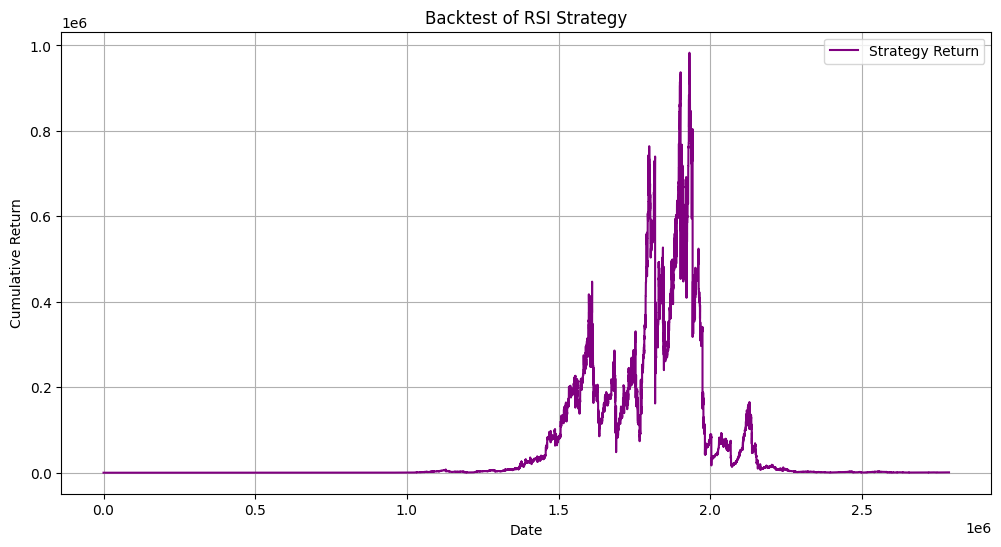

In [41]:
def backtest_rsi(data, rsi_buy=30, rsi_sell=70):
    # Inicializar a coluna de retornos da estratégia
    data['Position'] = 0

    # Regras de compra e venda
    data.loc[data['RSI'] < rsi_buy, 'Position'] = 1  # Comprar
    data.loc[data['RSI'] > rsi_sell, 'Position'] = -1  # Vender

    # Calcular os retornos da estratégia
    data['Strategy_Return'] = data['Position'].shift(1) * data['1_d_returns']

    # Calcular os retornos cumulativos
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

    return data['Cumulative_Strategy_Return']

# Executar o backtest
total_returns['Strategy_Return'] = backtest_rsi(total_returns)

# Resetar o índice para evitar problemas de MultiIndex
total_returns.reset_index(inplace=True)

# Plotar os retornos da estratégia
plt.figure(figsize=(12, 6))
plt.plot(total_returns['Strategy_Return'], label='Strategy Return', color='purple')
plt.title('Backtest of RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


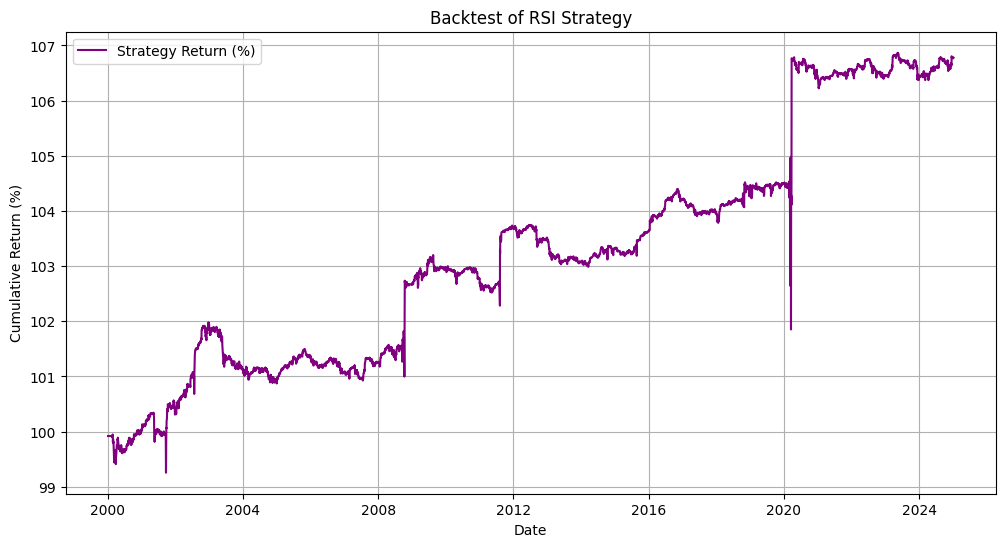

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========================
# ✅ Cálculo do RSI
# ========================
def calculate_rsi(returns, window=14):
    gain = np.where(returns > 0, returns, 0)
    loss = np.where(returns < 0, abs(returns), 0)
    
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    
    avg_loss.replace(0, 1e-10, inplace=True)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# ========================
# ✅ Backtest da Estratégia RSI
# ========================
def backtest_rsi(data, rsi_buy=30, rsi_sell=70):
    if 'RSI' not in data.columns:
        data['RSI'] = calculate_rsi(data['1_d_returns'])

    data['Position'] = 0
    data.loc[data['RSI'] < rsi_buy, 'Position'] = 1
    data.loc[data['RSI'] > rsi_sell, 'Position'] = -1

    data['Strategy_Return'] = data['Position'].shift(1) * data['1_d_returns']

    return data

# ========================
# ✅ Ajuste do DataFrame
# ========================
# Converter a coluna RSI_Bin para uma coluna normal (não categórica)
if 'RSI_Bin' in total_returns.columns:
    total_returns['RSI_Bin'] = total_returns['RSI_Bin'].astype(str)

# Preencher valores nulos com 0
total_returns.fillna(0, inplace=True)

# Limitar os retornos diários a um intervalo razoável
total_returns['1_d_returns'] = total_returns['1_d_returns'].clip(lower=-1, upper=1)

if 'Date' in total_returns.columns:
    total_returns['Date'] = pd.to_datetime(total_returns['Date'])
else:
    total_returns.reset_index(inplace=True)
    total_returns['Date'] = pd.to_datetime(total_returns['Date'])

total_returns.set_index('Date', inplace=True)

# ========================
# ✅ Calcular o Retorno Cumulativo Consolidado
# ========================
average_strategy_return = total_returns.groupby('Date')['Strategy_Return'].mean()
cumulative_return = (1 + average_strategy_return).cumprod()

# ========================
# ✅ Plotagem do Gráfico Corrigido
# ========================
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return.index, cumulative_return * 100, label='Strategy Return (%)', color='purple')
plt.title('Backtest of RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()
